<a href="https://colab.research.google.com/github/ravi-teja-sunkara/Super-Resolution-GAN/blob/master/SRGAN_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing libraries
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, MaxPooling2D
from keras.applications import VGG19
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
import datetime
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import cv2
from keras.layers import add
from keras.applications import VGG19
import keras.backend as K
from tqdm import tqdm_notebook
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
def res_block_gen(model, kernal_size, filters, strides):
    gen = model
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    # Using Parametric ReLU
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)

    model = add([gen, model])

    return model


def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_vgg_cnn_64x64/dcgan_%d_loss_epoch.png' % epoch)

In [4]:
def up_sampling_block(model, kernal_size, filters, strides):
    #model = Conv2DTranspose(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = UpSampling2D(size = 2)(model)
    model = LeakyReLU(alpha = 0.2)(model)

    return model

def discriminator_block(model, filters, kernel_size, strides):

    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = LeakyReLU(alpha = 0.2)(model)

    return model

In [5]:
def get_gan_network(discriminator, shape, generator, optimizer, vgg_loss):
    discriminator.trainable = False
    gan_input = Input(shape=shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss=[vgg_loss, "binary_crossentropy"],
                loss_weights=[1., 1e-3],
                optimizer=optimizer)

    return gan

In [6]:
def datagen(batchSize,filesList,filePath):
    while(True):
        files = np.random.choice(filesList,batchSize,replace=False)
        X_train_HR = []
        X_train_LR = []
        for file in files:
            image = cv2.imread(filePath + "/" + file)
#             print(filePath + "/" + file)
#             print(image)
            image_HR = cv2.resize(image,(224,224),interpolation = cv2.INTER_CUBIC)
            image_HR = image_HR / 255.0
            X_train_HR.append(image_HR)
            
            image_LR = cv2.resize(image,(56,56),interpolation = cv2.INTER_CUBIC)
            image_LR = image_LR / 255.0
            
            X_train_LR.append(image_LR)
            
        X_train_HR = np.array(X_train_HR)
        X_train_LR = np.array(X_train_LR)
        yield X_train_LR,X_train_HR

In [7]:
def plotGeneratedImages(epoch,datagen,generator, examples=100, dim=(1, 1), figsize=(2, 2)):
    randomDim = 100
    low,hit = next(datagen)
    generatedImages = generator.predict(low)
    fig = plt.figure(figsize=(10,1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(10):
        ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        ax.imshow((generatedImages[i]*255).astype(np.uint8))
    fol = 'images/gan_vgg_cnn_64x64/faces/'
    if not os.path.exists(fol):
        os.makedirs(fol)
    plt.savefig(fol+'random_{:05d}.png'.format(epoch))

def saveModels(epoch,generator,discriminator):
    fol = 'models/gan_vgg_cnn_64x64/'
    if not os.path.exists(fol):
        os.makedirs(fol)
    generator.save(fol+'dcgan_generator_epoch_%d.h5' % epoch)
    discriminator.save(fol+'dcgan_discriminator_epoch_%d.h5' % epoch)

In [8]:
# extracting the dataset

# filePath_train_LR = 'Desktop/spring2019/Aml/proj3/dataset/DIV2K_train_LR_x8'
# filePath_val_LR = 'Desktop/spring2019/Aml/proj3/dataset/DIV2K_valid_LR_x8'
filePath_val_HR = 'DIV2K_valid_HR'
filePath_train_HR = 'DIV2K_train_HR'
#filePath_val_HR = 'Desktop/spring2019/Aml/proj3/dataset/DIV2K_valid_HR'

# datagenObj = datagen(batch_count,train_HR,filePath_train_HR)
    
train_HR = os.listdir(filePath_train_HR)
valid_HR = os.listdir(filePath_val_HR)
# train_HR

In [9]:
batch_size = 10
tg = datagen(batchSize=batch_size,filePath=filePath_train_HR,filesList=train_HR)
vg = datagen(batchSize=batch_size,filePath=filePath_val_HR,filesList=valid_HR)
x,y = next(tg)

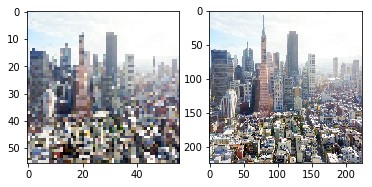

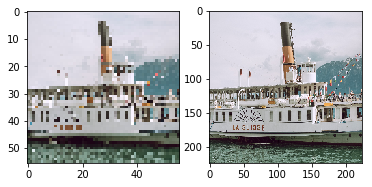

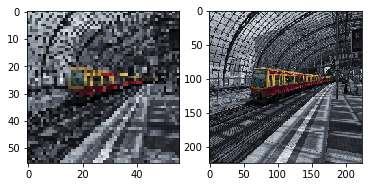

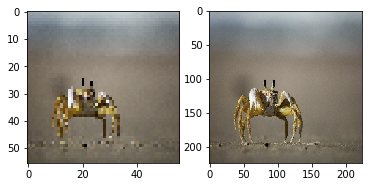

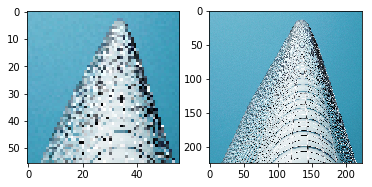

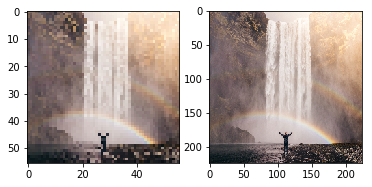

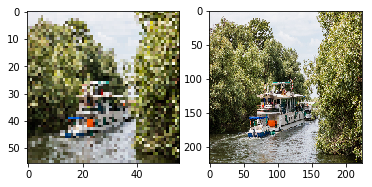

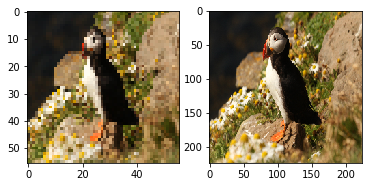

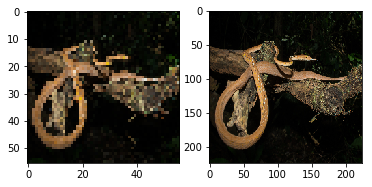

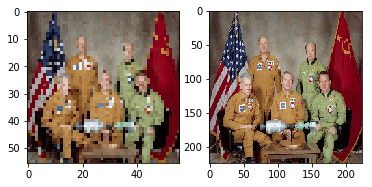

In [10]:
for i in range(batch_size):
    fig, ax = plt.subplots(nrows=1,ncols=2)
    ax[0].imshow(x[i][:,:,::-1])
    ax[1].imshow(y[i][:,:,::-1])

In [11]:
class Generator():
    def __init__(self, noise_shape):
        self.noise_shape = noise_shape
        
    def gen(self):
        gen_Input = Input(shape = self.noise_shape)
        
        
        model = Conv2D(filters = 64,kernel_size = 9 ,strides=1,padding = "same") (gen_Input)
        model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
        
        for i in range(16):
            model = res_block_gen(model,3,64,1)
            
            
        for i in range(2):
            model = up_sampling_block(model,3,256,1)
        
        model = Conv2D(filters = 3,kernel_size=9,strides=1,padding="same")(model)
        model = Activation('tanh')(model)
        
        generator_model = Model(inputs = gen_Input, outputs = model)
        
        return generator_model

In [12]:
class Disciminator():
    def __init__(self, image_shape):
        
        self.image_shape = image_shape
        
        
    def disc(self):
        disc_Input = Input(shape = self.image_shape)
        
        model = Conv2D(filters = 64,kernel_size = 3 ,strides=1,padding = "same") (disc_Input)
        model = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(model)
        model = LeakyReLU(alpha = 0.2)(model)
        
        
        model = discriminator_block(model, 64, 3, 1)
        model = discriminator_block(model, 128, 3, 1)
        model = discriminator_block(model, 128, 3, 1)
        model = discriminator_block(model, 256, 3, 1)
        model = discriminator_block(model, 256, 3, 1)
        model = discriminator_block(model, 512, 3, 1)
        model = discriminator_block(model, 512, 3, 1)
        
        model = Flatten()(model)
        
        model = Dense(1024)(model)
        model = LeakyReLU(alpha = 0.2)(model)
        
        model = Dense(1)(model)
        model = Activation('sigmoid')(model)
        
        disciminator_model = Model(inputs = disc_Input,output = model)
        
        
        return disciminator_model

In [13]:
class VGG(object):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape

    # computes VGG loss or content loss
    def vgg_loss(self, y_true, y_pred):
    
        vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=self.image_shape)
        vgg19.trainable = False
        # Make trainable as False
        for l in vgg19.layers:
            l.trainable = False
        model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
        model.trainable = False
    
        return K.mean(K.square(model(y_true) - model(y_pred)))

In [14]:
image_HR_shape = (224,224,3)
image_SR_shape = (56,56,3)
optimizer = Adam(lr=0.0001)
no_of_epoch = 50
d_loss = []
g_loss = []

In [15]:
loss = VGG(image_HR_shape)
     
#making the generator network to predict image by supplying low resolution input

generator = Generator(image_SR_shape).gen()
discriminator = Disciminator(image_HR_shape).disc()

# vgg_optimizer = loss.get_optimizer()
generator.compile(loss=loss.vgg_loss, optimizer=optimizer)
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer)
    

/home/rbc/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 56, 56, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 56, 56, 64)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 56, 56, 64)   36928       p_re_lu_1[0][0]                  
__________________________________________________________________________________________________
batch_norm

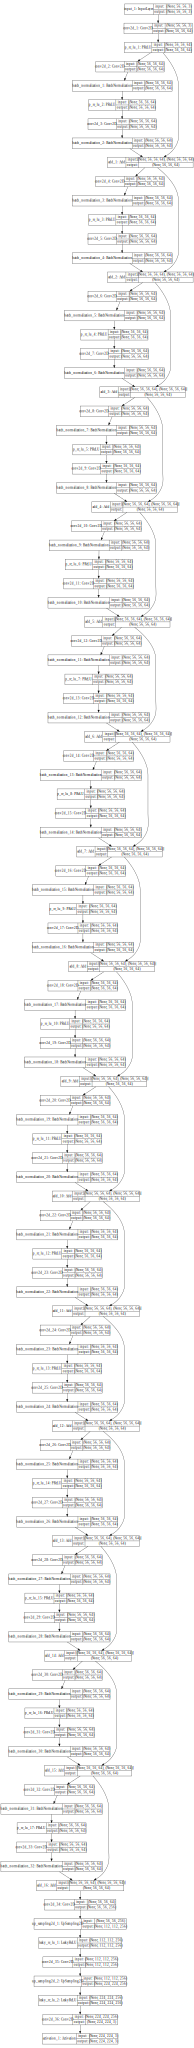

In [16]:
generator.summary()
SVG(model_to_dot(generator, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 56, 56, 64)        256       
__________

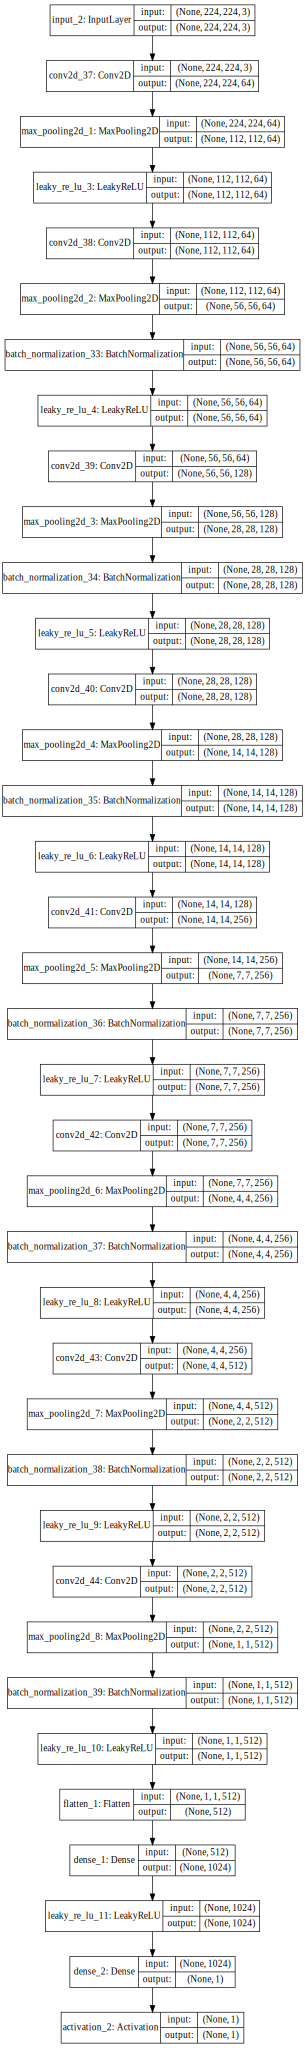

In [17]:
discriminator.summary()
SVG(model_to_dot(discriminator, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 56, 56, 3)         0         
_________________________________________________________________
model_1 (Model)              (None, 224, 224, 3)       2006595   
_________________________________________________________________
model_2 (Model)              (None, 1)                 5219137   
Total params: 7,225,732
Trainable params: 2,002,499
Non-trainable params: 5,223,233
_________________________________________________________________


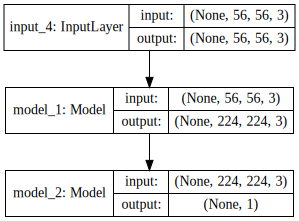

In [18]:
gan = get_gan_network(discriminator, image_SR_shape, generator, optimizer, loss.vgg_loss)
gan.summary()
SVG(model_to_dot(gan, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# def train():
    
steps = 1
disc_steps = 10    

for e in tqdm_notebook(range(1,no_of_epoch)):
    for b in range(steps):
        discriminator.trainable = True
        for _ in range(disc_steps):
            lr_img,hr_img = next(tg)
            fake_img = generator.predict(lr_img)
            #inputDisc = np.concatenate([hr_img,fake_img])
            real_data_Y = np.ones(batch_size) - 0.1
            fake_data_Y = np.zeros(batch_size)

            # training the disciminator
            d_loss_real = discriminator.train_on_batch(hr_img, real_data_Y) #ones
            d_loss_fake = discriminator.train_on_batch(fake_img, fake_data_Y) #zeros
        dloss = 0.5 * np.add(d_loss_fake, d_loss_real)

       # dloss = discriminator.train_on_batch(inputDisc, target_value)

        #training the generator
        #generator is frozen
        lr_img,hr_img = next(tg)
        target_value = np.ones(batch_size)
        discriminator.trainable = False
        gan_loss = gan.train_on_batch(lr_img, [hr_img,target_value])

    d_loss.append(dloss)
    g_loss.append(gan_loss)

    if e == 1 or e % 5 == 0:
        saveModels(e,generator,discriminator)
        plotGeneratedImages(e,tg,generator)
       # plotGeneratedImages(e)
#             saveModels(e)

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(d_loss, label='Discriminitive loss')
plt.plot(g_loss, label='Generative loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('images/gan_vgg_cnn_64x64/dcgan_%d_loss_epoch.png' % no_of_epoch)